## Download Compustat data from WRDS

-------------------------

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import wrds

### Connect WRDS

In [2]:
conn=wrds.Connection()

Enter your WRDS username [yjaey]: yjaeyoon
Enter your password: ···············


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
Loading library list...
Done


### Download funda from Compustat

In [3]:
df= conn.raw_sql(f"""select conm, gvkey, cik, tic, datadate, au, fyear, at, lt, sale,  ni, ib, oancf, sich, prcc_f * csho as mv
                    from comp.funda a
                    
                    where a.fyear >= 1990 and 
                        a.fyear <= 2020 and
                        a.indfmt= 'INDL' and 
                        a.datafmt = 'STD' and 
                        a.popsrc= 'D' and 
                        a.consol = 'C'
                    """)
df=df.dropna(subset=['cik', 'at', 'sale', 'sich'])
df= df.sort_values(['gvkey','datadate'])
df['fyear']= df['fyear'].astype(int)
df['lev']= df['lt'] / df['at']
df= df.reset_index(drop=True)
print(df.shape)
df.head()

(238413, 16)


,conm,gvkey,cik,tic,datadate,au,fyear,at,lt,sale,ni,ib,oancf,sich,mv,lev
0,AAR CORP,001004,0000001750,AIR,1991-05-31,6,1990,379.958,186.180,466.542,14.801,14.801,36.891,5080.0,224.460360,0.490002
1,AAR CORP,001004,0000001750,AIR,1992-05-31,6,1991,395.351,198.614,422.657,10.020,10.020,8.814,5080.0,204.699595,0.502374
2,AAR CORP,001004,0000001750,AIR,1993-05-31,6,1992,365.151,175.935,382.780,0.283,0.283,16.806,5080.0,214.663477,0.481814
3,AAR CORP,001004,0000001750,AIR,1994-05-31,6,1993,417.626,228.138,407.754,9.494,9.484,6.697,5080.0,228.648720,0.546273
4,AAR CORP,001004,0000001750,AIR,1995-05-31,6,1994,425.814,228.695,451.395,10.463,10.463,15.255,5080.0,243.405235,0.537077


In [4]:
df['industrial']= 1
df.loc[(df.sich >= 6000) & (df.sich < 7000), 'industrial']= 0

df_all= df                     # all firms
df_ind= df[df.industrial==1]   # indusrial firms
df_fin= df[df.industrial==0]   # finance firms

In [5]:
df['sic2']= (df['sich']/100).astype(int)

df.loc[df.sic2 <= 9, 'industry']= 'Agriculture, Forest, Fishing'
df.loc[(df.sic2 >= 10) & (df.sic2 <= 14), 'industry']= 'Mining'
df.loc[(df.sic2 >= 15) & (df.sic2 <= 17), 'industry']= 'Construction'
df.loc[(df.sic2 >= 20) & (df.sic2 <= 39), 'industry']= 'Manufacturing'
df.loc[(df.sic2 >= 40) & (df.sic2 <= 49), 'industry']= 'Trans. & Public Utilities'
df.loc[(df.sic2 >= 50) & (df.sic2 <= 51), 'industry']= 'Wholesale Trade'
df.loc[(df.sic2 >= 52) & (df.sic2 <= 59), 'industry']= 'Retail Trade'
df.loc[(df.sic2 >= 60) & (df.sic2 <= 67), 'industry']= 'Finance, Insurance, Real Estate'
df.loc[(df.sic2 >= 70) & (df.sic2 <= 89), 'industry']= 'Services'
df.loc[(df.sic2 >= 91) & (df.sic2 <= 99), 'industry']= 'Public Administration'

---------------------

## Check data with visualization

### Distribution by years

In [6]:
df_plot= df_all.groupby(['fyear', 'industrial']).size().reset_index().pivot(index= 'fyear', columns='industrial', values= 0)
df_plot.head()

industrial,0,1
fyear,,
1990,777,6038
1991,825,6179
1992,889,6567
1993,1019,6923
1994,1045,7318


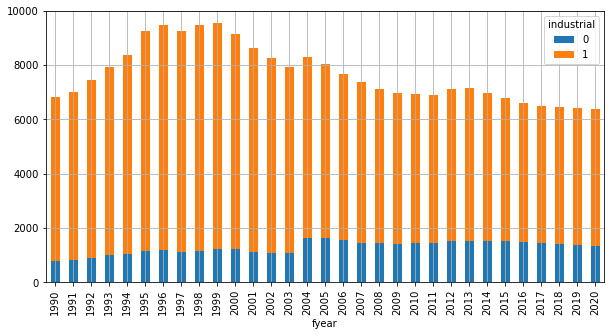

In [7]:
df_plot.plot(kind='bar', grid= True, stacked= True, figsize= (10,5))
plt.show()

<em>Increase in the number of financial firms in 2004? </em>

### Sum of total assets, Revenues, and MV by years

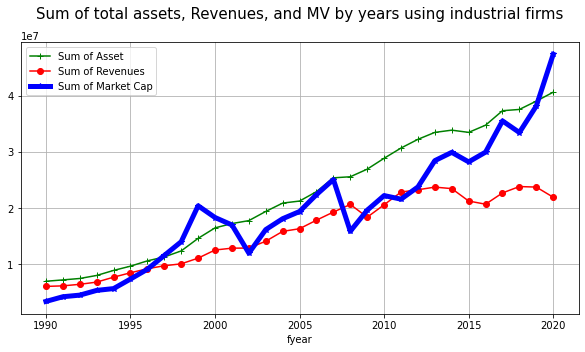

In [8]:
df_ind.groupby(['fyear']).sum()['at'].plot(kind='line', color= 'g', marker='+', label= 'Sum of Asset')
df_ind.groupby(['fyear']).sum()['sale'].plot(kind='line', color= 'r', marker='o', label= 'Sum of Revenues')
df_ind.groupby(['fyear']).sum()['mv'].plot(kind='line', figsize=(10,5), grid= True, color= 'b', marker='*', lw= 5, label= 'Sum of Market Cap')
plt.legend()

plt.title("Sum of total assets, Revenues, and MV by years using industrial firms\n", fontsize= 15)
plt.show()

* <em>Sum of MV decreased in 2000 (DotCom bubble) and 2008 (Financial Crisis) substantially.</em>
* As shown in the yearly distribution of number of obs earlier, some non-finance firms may be reclassified into finance firms in year 2004, resulting in the decrease of assets in 2004.

### Sum of Net Income and Operating Cash Flows

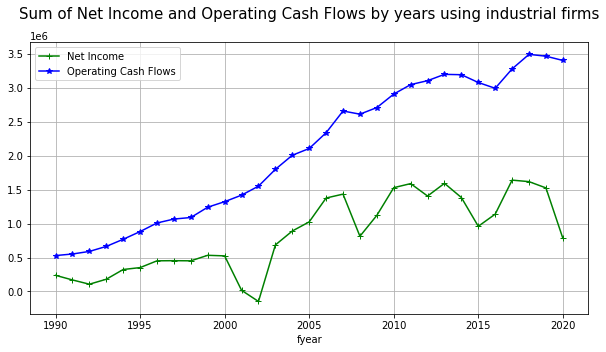

In [9]:
df_ind.groupby(['fyear']).sum()['ni'].plot(kind='line', color= 'g', marker='+', label= 'Net Income')
df_ind.groupby(['fyear']).sum()['oancf'].plot(kind='line', figsize=(10,5), grid= True, color= 'b', marker='*', label= 'Operating Cash Flows')
plt.legend()
plt.title("Sum of Net Income and Operating Cash Flows by years using industrial firms\n", fontsize= 15)
plt.show()

-------------

### Save dataframe to .csv

In [13]:
df.head(2)

,conm,gvkey,cik,tic,datadate,au,fyear,at,lt,sale,ni,ib,oancf,sich,mv,lev,industrial,sic2,industry
0,AAR CORP,001004,0000001750,AIR,1991-05-31,6,1990,379.958,186.180,466.542,14.801,14.801,36.891,5080.0,224.460360,0.490002,1,50,Wholesale Trade
1,AAR CORP,001004,0000001750,AIR,1992-05-31,6,1991,395.351,198.614,422.657,10.020,10.020,8.814,5080.0,204.699595,0.502374,1,50,Wholesale Trade


In [10]:
df.to_csv("data/compustat_from_1990.csv", index= None)

### Close connection

In [11]:
conn.close()